<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/7RO/UT1/T1/7RO_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Diseño del laberinto**

## Librerías y clases

En primer lugar, para movernos por el laberinto se ha hecho uso de tres clases:

*   Una clase Place, con atributos col y row, que indica una posición del laberinto.
*   Una clase Agent con métodos para cambiar de posición en el laberinto.
*   Una clase Displacement a modo de vector para calcular las nuevas posiciones.

In [88]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import LinearSegmentedColormap

#Define functions

#Define class Place with coordinates row,col
class Place():
  def __init__(self, row=1, col=1):
    self.row = row
    self.col = col

#Define class Displacement with axis x,y
class Displacement():
  def __init__(self,x=0,y=0):
    self.x = x
    self.y = y
  def apply_to(self, place:Place):
    new_row = place.row + self.x
    new_col = place.col + self.y
    return Place(new_row, new_col)

#Define class Agent with his position
class Agent():
  def __init__(self, place=Place()):
    self.place = place
  def teleport(self, place):
    self.place = place
  def move(self, moves, direction):
    displacement = Displacement(moves[direction][0], moves[direction][1])
    self.place = displacement.apply_to(self.place)
  def check_move(self, moves, direction):
    displacement = Displacement(moves[direction][0], moves[direction][1])
    return displacement.apply_to(self.place)

## Funciones de generación de laberinto y muros

A continuación, se han definido funciones para crear el laberinto y sus muros de las cuatro formas antes vistas:
*   Laberinto vacío concatenado con arrays horizontales y verticales a una matriz con valores que representar a una posición donde existe un muro.
*   Laberinto asignando manualmente el valor que representan los muros.
*   Laberinto que asigna un valor aleatorio a cada punto del laberinto.
*   Laberinto aleatorio mediante algoritmo que va creando rutas.

El algoritmo aleatorio ha sido inventado desde cero y funciona de la siguiente manera:
1.	Pone el laberinto a un valor diferente al de camino y muro, respetando inicio, fin y muros interiores.
2.	Comenzando del punto inicial localiza las direcciones en la que podría desplazarse una instancia de agente y si hay más de una se añade la posición a una lista para crear ramificaciones.
3.	Si no hubiera direcciones a las que moverse nos moveríamos a otra posición aleatoria de la lista. Al movernos la borramos de la lista.
4.	Se amplía el camino eligiendo una dirección al azar a la que movernos y cambiando el valor de la nueva celda.
5.	Desde la nueva celda comprobamos las 5 posiciones adyacentes al lado opuesto de la celda de la que se proviene. Para ello se rota el vector de 8 movimiento para coger esas 5 direcciones como las 5 primeras posiciones.
6.	Si existe un camino en las celdas adyacentes pone la celda actual como un muro y nos movemos aleatoriamente a una de las celdas de la lista.
7.	Si existe camino se vuelve al paso 2 desde la celda en que se han comprobado las celdas adyacentes.
8.	El bucle termina cuando no existen celdas en la lista para crear ramificaciones.
9.	Finalmente, se ponen como muros las celdas que hayan quedado sin modificar.


In [126]:
#Define function empty_maze, an empty space rounded of  walls.
def empty_maze(h, w, v_empty, v_wall, v_init, v_goal, init_place, end_place):
  def wall(n, v_wall):
    return np.ones([1,n], dtype=int)*v_wall
  maze = np.ones([h-2, w-2], dtype=int)*v_empty
  maze = np.concatenate([wall(h-2,v_wall).T, maze, wall(h-2,v_wall).T], axis=1)
  maze = np.concatenate([wall(w,v_wall), maze, wall(w,v_wall)], axis=0)
  maze[init_place.row, init_place.col] = v_init
  maze[end_place.row, end_place.col] = v_goal
  return maze

#Functions to fill the maze
#Fixed walls
def add_fixed_walls(maze_empty, v_wall, init_place, end_place):
  maze = np.copy(maze_empty)
  init_value = maze_empty[init_place.row, init_place.col]
  end_value = maze_empty[end_place.row, end_place.col]
  maze[6:9,3]=v_wall
  maze[1:8,5]=v_wall
  maze[3,2:4]=v_wall
  maze[5,1:3]=v_wall
  maze[4,7:9]=v_wall
  maze[6:9,7]=v_wall
  maze[init_place.row, init_place.col] = maze_empty[init_place.row, init_place.col]
  maze[end_place.row, end_place.col] = maze_empty[end_place.row, end_place.col]
  return maze

#Random points
def add_random_points(maze_empty, v_wall, v_empty, init_place, end_place):
  maze = np.copy(maze_empty)
  for row in range(1,maze.shape[0]-1):
    for col in range(1,maze.shape[1]-1):
      if (row != init_row or col != init_col) and (row != goal_row or col != goal_col):
        maze[row,col] = random.choice([v_wall,v_empty])
  maze[init_place.row, init_place.col] = maze_empty[init_place.row, init_place.col]
  maze[end_place.row, end_place.col] = maze_empty[end_place.row, end_place.col]
  return maze

#Random maze
def add_random_maze(maze_empty, v_wall, v_empty, init_place, end_place):
  moves_directions= np.array([[-1,0],[0,1],[1,0],[0,-1]])
  check_directions = np.array([[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1]])
  mark = np.copy(maze_empty)
  agent = Agent(Place(init_place.row,init_place.col))
  possible_directions = []
  alternative_available = [agent.place]
  direction = 0
  v_aux = -1

  #fill with v_aux
  for row in range(1,maze.shape[0]-1):
    for col in range(1,maze.shape[1]-1):
      if (row != init_place.row or col != init_place.col) and (row != end_place.row or col != end_place.col):
        mark[row,col] = v_aux

  #from current cell, choose one random direction and add new cell to list of nodes for new  paths
  while alternative_available:
    possible_directions.clear()
    #check free directions
    for i in range(moves_directions.shape[0]):
      adj_place = agent.check_move(moves_directions,i)
      if mark[adj_place.row, adj_place.col] == v_aux:
        possible_directions.append(i)
    #if two or more directions available save node to list
    if len(possible_directions) > 0:
      alternative_available.append(agent.place)
    #if no directions available teleport to random node in the list and remove it from it
    if not possible_directions:
      agent.teleport(random.choice(alternative_available))
      alternative_available.remove(agent.place)
    #move to random direction and mark it like empty
    else:
      new_direction = random.choice(possible_directions)
      agent.move(moves_directions, new_direction)
      mark[agent.place.row, agent.place.col] = v_empty
      #check 5 cells adjacents in the opposite side form previous position
      rolled_check_directions = np.roll(check_directions, (((new_direction*2)-2)*-2))
      for i in range(check_directions.shape[0]-3):
        adj_place = agent.check_move(rolled_check_directions,i)
        #if there is an empty cell adjacent to current change current to wall and telepor to random node in the list
        if mark[adj_place.row, adj_place.col] == v_empty:
          mark[agent.place.row, agent.place.col] = v_wall
          agent.teleport(random.choice(alternative_available))
          alternative_available.remove(agent.place)
          break;

  #fix v_aux to walls
  for row in range(1,maze.shape[0]-1):
    for col in range(1,maze.shape[1]-1):
      if mark[row,col] == v_aux:
        mark[row,col] = v_wall

  return mark

## Búsqueda en abanico o en amplitud (BFS)
El siguiente código muestra la función que ejecuta el algoritmo de búsqueda en amplitud para un laberinto, una matriz de movimiento y unos puntos final e inicial dados.

Se instancia un objeto de clase Agente que comprueba las casillas cercanas a los que puede llegar mediante la matriz o vector de movimientos para detectar aquellas que no se han detectado anteriormente. Se añade cada uno de esas casillas a una cola de tipo FIFO si su valor corresponde a vacías, se les asigna un valor en la matriz que se va incrementando gradualmente, y se elimina la actual. Acto seguido el agente de desplaza a la siguiente posición indicada en la cola.

El proceso se repite hasta que se encuentre la meta - “is_goal_reached” obtenga el valor True - o se vacíe la cola - “is_queue_empty” obtenga el valor True - porque se han dejado de encontrar casillas vacías a la que desplazarse.


In [127]:
#Resolve maze using breadth first search algorithm and filling visited cells with incremental values.
#Need maze matrix, moves matrix, and initial and final points,
def breadth_first_search(maze:np.ndarray, moves:np.ndarray, init:Place, goal:Place):
  mark = np.copy(maze)
  agent = Agent(init)
  fifo = [init]
  move_index = 1
  is_goal_reached = False
  is_queue_empty = False

  #Check adjacents cells and add to FIFO those not visited
  def search_adjacents_places():
    nonlocal move_index
    #teleport agent to the current square and check cells resulting from the movements
    for i in range(moves.shape[0]):
      adj_place = agent.check_move(moves,i)
      if mark[adj_place.row, adj_place.col] == VALUE_GOAL:
        print("Ha alcanzado la meta en", move_index, "movimientos!!")
        return True
      elif mark[adj_place.row, adj_place.col] == VALUE_EMPTY:
        fifo.append(adj_place)
        mark[adj_place.row, adj_place.col]=move_index*value_offset_step+VALUE_OFFSET_MIN
        move_index += 1
    return False;

  #check adjacentes of all cells added to queue (fifo) until find the goal
  while (not is_goal_reached) and (not is_queue_empty):
    agent.teleport(fifo.pop(0))
    is_goal_reached = search_adjacents_places()
    #check empty queue
    if not fifo:
      print("No ha encontrado la salida.")
      is_queue_empty = True

  return mark

## Búsqueda en profundidad (DFS)
El siguiente código muestra la función que ejecuta el algoritmo de búsqueda en profundidad para un laberinto, una matriz de movimiento y unos puntos final e inicial.

La estructura es similar, pero en este caso el agente comprueba una casilla cercana de acuerdo al vector del movimiento y si está vacía se desplaza a ella para repetir el proceso. Cada vez que se hace eso se guarda la nueva posición en una pila o “stack” (cola tipo LIFO) y se llama a la función de forma recursiva. En el caso de no encontrar casillas nuevas en una llamada a este método se devuelve False, se elimina la posición de la pila y se retorna a la posición anterior y al método que lo invocó, que seguirá comprobando las casillas adyacentes en el orden que indica el vector de movimientos.

Si se encuentra la salida se devuelve True, momento en el que dicho valor se devuelve de forma escalada en todas las llamadas que se habían producido de forma recursiva.

Al final se ha añadido una estructura que recoge las posiciones en la pila para pintar una copia del laberinto con el camino o solución hallada por el algoritmo. De modo que la función devuelve dos matrices


In [128]:
#Resolve maze using depth first search algorithm and filling visited cells with incremental values.
#Need maze matrix, moves matrix, and initial and final points,
def depth_first_search(maze:np.ndarray, moves:np.ndarray, init:Place, goal:Place):
  mark = np.copy(maze)
  agent = Agent(init)
  stack = [init]
  move_index = 1

  #Move to directions one by one trying differents routes
  def check_next_direction():
    nonlocal move_index
    for i in range(moves.shape[0]):
      #check cell resulting from the movements
      adj_place = agent.check_move(moves,i)
      if mark[adj_place.row, adj_place.col] == VALUE_GOAL:
        return True
      elif mark[adj_place.row, adj_place.col] == VALUE_EMPTY:
        #move to first empty cell found and add it to stack (LIFO)
        agent.move(moves,i)
        stack.append(adj_place)
        mark[adj_place.row, adj_place.col]=move_index*value_offset_step+VALUE_OFFSET_MIN
        move_index += 1
        #check movements from the new position.
        if check_next_direction():
          return True
        #If no path, back to the previous one and delete cell from stack (LIFO)
        agent.move(moves*-1,i)
        stack.pop()
    return False;

  if check_next_direction():
    print("Ha alcanzado la meta en", move_index, "movimientos!!")
  else:
    print("No ha encontrado la salida.")

  mark_solution = np.copy(maze)
  for place in stack[1:]:
    mark_solution[place.row, place.col] = VALUE_OFFSET_MAX+value_offset_step

  return mark, mark_solution

# **Preparación del laberinto**

## Parámetros del laberinto y del espacio de colores
Seguidamente se han definido variables para parametrizar el laberinto en caso de que se quiera variar alguna característica como el tamaño, posiciones inicial y final, color o los laberintos a visualizar.

Existe una variable mazes_to_show que permitirá que no se usen ni se visualicen los laberintos  que no se deseen.

Las constantes se han ajustado para que la representación se amolde al esquema de colores propuesto en la actividad (naranja, verde, gris y blanco), añadiendo el violeta para ayudar a representar las soluciones de manera clara. Se han mantenido los valores excepto para el espacio, que se ha fijado a 1.5 y se han propuesto otras variables que indican un rango de valores en los que asignaran valores equiespaciados gracias a un variable de paso.

La lista de colores es asignada a un mapa de color para visualizar las matrices como imágenes, añadiendo título y una leyenda con la escala de colores, quitando los valores de los ejes y añadiendo texto a las casillas que rellenen los algoritmos para recuperar información del orden en que se rellenaron.

Además, se han creado dos matrices para definir los posibles movimientos. La comentada antes, con 4 movimientos, y una extendida con 8 movimientos que permite moverse diagonalmente.

Se ha creado una función para visualizar los laberintos a partir de la matriz, indicándole el lugar donde dibujarla, un título y si se quiere mostrar la barra de color. Además, al final se extrae la información numérica de la matriz para representar con números las casillas en el rango de valores que se asignan a las casillas que se van visitando, como se dijo en el párrafo anterior.
El mapa de colores se configura con el vector de colores mencionado antes para mantener los colores propuestos.


In [162]:
#MAZE PARAMETERS TO CONFIGURE
height=10
width=10
init_row = 1
init_col = 1
goal_row = height-2
goal_col = width-2

#SHOW PARAMETERS TO CONFIGURE
mazes_to_show = [1,1,1,1] #empty, fixed, filled, random
fig_width = 4*width/10
fig_height = 3*height/10

#Spacecolor parameters
# Grey(1) -> White(1.5) -> Orange(2) -> Purple(2.5) -> Green(3)
COLORS = [(.7,.7,.7), (1,1,1), (1,.5,0), (0.5,0,0.5), (0,1,0)]
VALUE_WALL = 1
VALUE_EMPTY = 1.5
VALUE_INIT = 2
VALUE_GOAL = 3
VALUE_OFFSET_MAX=2.9
VALUE_OFFSET_MIN=2.1

#Moves matrix
MOVES4 = np.array([[-1,0],[0,1],[1,0],[0,-1]])
MOVES8 = np.array([[-1,0],[-1,1],[0,1],[1,1],[1,0],[1,-1],[0,-1],[-1,-1]])

#Other vars
start_position = Place(init_row, init_col)
goal_position = Place(goal_row, goal_col)
cmap = LinearSegmentedColormap.from_list('maze', COLORS, N=height*width*3)
value_offset_step = (VALUE_OFFSET_MAX-VALUE_OFFSET_MIN)/((height-2)*(width-2))

#Function for visualizate mazes
def visualize_example(maze, ax, title, show_colorbar=False):
  im = ax.imshow(maze, cmap=cmap)
  ax.set_title(title)
  ax.axis(False)
  if show_colorbar:
    plt.colorbar(im, ax=ax, fraction=0.046)
  for (i,j),label in np.ndenumerate(maze):
    if maze[i][j] <= VALUE_OFFSET_MAX and maze[i][j] >= VALUE_OFFSET_MIN:
      ax.text(j,i,int(round((label-VALUE_OFFSET_MIN)/value_offset_step)),ha='center',va='center')

## Creación de laberintos

Finalmente se crear el laberinto vacío y los tres modelos con muros llamando a las funciones declaradas anteriormente. Además, se llama a la función de visualización para representar los laberintos como se pudo ver en la introducción. Se pueden crear y ver los laberintos que se quieran (el vacío es creado siempre) según los valores asignados a la variable mazes_to_show. El resultado es el mostrado en la introducción.

Para visualizar todos los resultados conjuntamente se han ido añadiendo subplots, dividiendo la figura en una matriz de tamaño variable según las gráficas a mostrar e indicando la posición ordenada de cada una.

Para visualizarlos se ha llamado a la función definida anteriormente, indicando la matriz del laberinto a representar, el subplot donde se pintará, un título y si se va a mostrar la barra de colores.



In [ ]:
## Create mazes

#Create empty maze with init and end points
maze = empty_maze(height, width, VALUE_EMPTY, VALUE_WALL, VALUE_INIT, VALUE_GOAL, start_position, goal_position)

#Create and show chosen mazes with walls running filling algorithms
n_mazes = sum(mazes_to_show)
idx_ax = 1

if n_mazes:
  fig = plt.figure(figsize=(n_mazes*fig_width,fig_height))
  #Empty maze
  if mazes_to_show[0]:
    ax = fig.add_subplot(1, n_mazes, idx_ax)
    visualize_example(maze,ax,'Laberinto Vacío', idx_ax == n_mazes)
    idx_ax += 1
  #Fixed maze
  if mazes_to_show[1]:
    maze_fixed = add_fixed_walls(maze, VALUE_WALL, start_position, goal_position)
    ax = fig.add_subplot(1, n_mazes, idx_ax)
    visualize_example(maze_fixed,ax,'Laberinto Fijo', idx_ax == n_mazes)
    idx_ax += 1
  #Maze filled with points
  if mazes_to_show[2]:
    maze_filled = add_random_points(maze, VALUE_WALL, VALUE_EMPTY, start_position, goal_position)
    ax = fig.add_subplot(1, n_mazes, idx_ax)
    visualize_example(maze_filled,ax,'Puntos aleatorio', idx_ax == n_mazes)
    idx_ax += 1
  #Random maze
  if mazes_to_show[3]:
    maze_random = add_random_maze(maze, VALUE_WALL, VALUE_EMPTY, start_position, goal_position)
    ax = fig.add_subplot(1, n_mazes, idx_ax)
    visualize_example(maze_random,ax,'Laberinto Aleatorio', idx_ax == n_mazes)


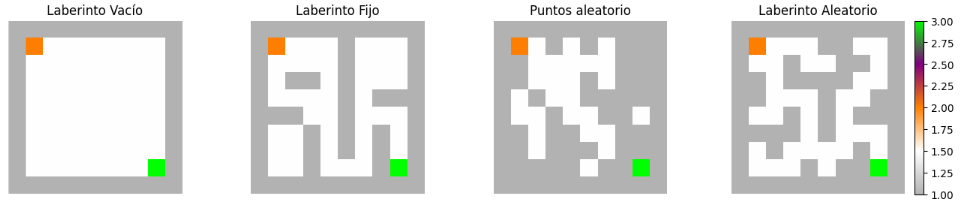

# **Visualización de soluciones**
## Algoritmo en amplitud BFS con 4 y 8 movimientos
La forma de representarlas es idéntica a como se hizo para los laberintos sin resolver, pero en este caso colocando las figuras en dos filas sabiendo que el índice de una posición en una fila es la suma del índice de la figura de arriba y el número de columnas.

In [ ]:
#Visualize results with BFS
if n_mazes:
  fig = plt.figure(figsize=(n_mazes*fig_width,2*fig_height))
  idx_ax = 1
  #Empty maze
  if mazes_to_show[0]:
    #4 moves
    print('\nLaberinto vacío - BFS con 4 movimientos:')
    mark = breadth_first_search(maze, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Laberinto Vacío (BFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto vacío - BFS con 8 movimientos:')
    mark = breadth_first_search(maze, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Laberinto Vacío (BFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  #Fixed maze
  if mazes_to_show[1]:
    #4 moves
    print('\nLaberinto fijo - BFS con 4 movimientos:')
    mark = breadth_first_search(maze_fixed, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Laberinto fijo (BFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto fijo - BFS con 8 movimientos:')
    mark = breadth_first_search(maze_fixed, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Laberinto fijo (BFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  #Filled maze
  if mazes_to_show[2]:
    #4 moves
    print('\nPuntos aleatorios - BFS con 4 movimientos:')
    mark = breadth_first_search(maze_filled, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Puntos aleatorios (BFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Puntos aleatorios - BFS con 8 movimientos:')
    mark = breadth_first_search(maze_filled, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Puntos aleatorios (BFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  if mazes_to_show[3]:
    #4 moves
    print('\nLaberinto aleatorio - BFS con 4 movimientos:')
    mark = breadth_first_search(maze_random, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Laberinto aleatorio (BFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto aleatorio - BFS con 8 movimientos:')
    mark = breadth_first_search(maze_random, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Laberinto aleatorio (BFS x8) ', idx_ax == n_mazes)
    idx_ax += 1

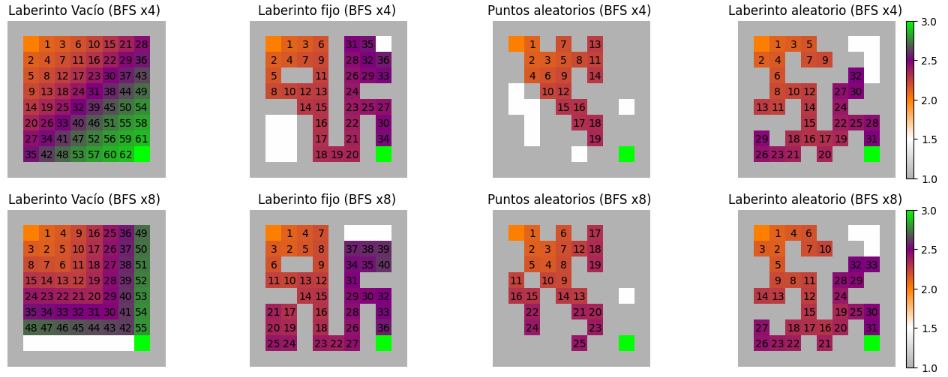













































## Algoritmo en profundidad DFS con 4 y 8 movimientos
El código es idéntico al mostrado para visualizar las soluciones al algoritmo BFS pero sustituyendo nombres de funciones, títulos y teniendo en cuenta que esta función devuelve dos matrices en lugar de una.

In [ ]:
#Visualize results with BFS
if n_mazes:
  fig = plt.figure(figsize=(n_mazes*fig_width,2*fig_height))
  idx_ax = 1
  #Empty maze
  if mazes_to_show[0]:
    #4 moves
    print('\nLaberinto vacío - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Laberinto Vacío (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto vacío - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Laberinto Vacío (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  #Fixed maze
  if mazes_to_show[1]:
    #4 moves
    print('\nLaberinto fijo - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze_fixed, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Laberinto fijo (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto fijo - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze_fixed, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Laberinto fijo (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  #Filled maze
  if mazes_to_show[2]:
    #4 moves
    print('\nPuntos aleatorios - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze_filled, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Puntos aleatorios (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Puntos aleatorios - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze_filled, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Puntos aleatorios (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  if mazes_to_show[3]:
    #4 moves
    print('\nLaberinto aleatorio - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze_random, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark,ax,'Laberinto aleatorio (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto aleatorio - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze_random, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark,ax,'Laberinto aleatorio (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1

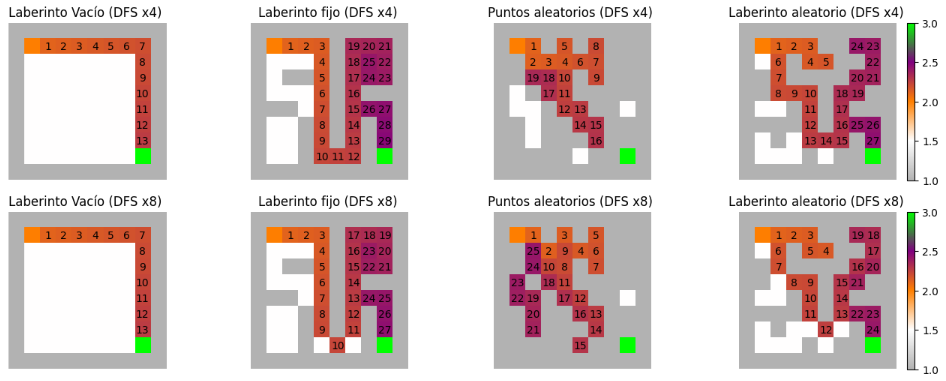

## Algoritmo en profundidad DFS con 4 y 8 movimientos (Camino resultante)
Para representar las soluciones de forma separada se ha repetido el código en otra célula del cuaderno y sustituido la matriz a visualizar entre las dos que nos devuelve el algoritmo.

In [ ]:
#Visualize results with BFS
if n_mazes:
  fig = plt.figure(figsize=(n_mazes*fig_width,2*fig_height))
  idx_ax = 1
  #Empty maze
  if mazes_to_show[0]:
    #4 moves
    print('\nLaberinto vacío - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark_solution,ax,'Laberinto Vacío (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto vacío - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark_solution,ax,'Laberinto Vacío (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  #Fixed maze
  if mazes_to_show[1]:
    #4 moves
    print('\nLaberinto fijo - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze_fixed, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark_solution,ax,'Laberinto fijo (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto fijo - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze_fixed, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark_solution,ax,'Laberinto fijo (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  #Filled maze
  if mazes_to_show[2]:
    #4 moves
    print('\nPuntos aleatorios - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze_filled, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark_solution,ax,'Puntos aleatorios (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Puntos aleatorios - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze_filled, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark_solution,ax,'Puntos aleatorios (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1
  if mazes_to_show[3]:
    #4 moves
    print('\nLaberinto aleatorio - DFS con 4 movimientos:')
    mark, mark_solution = depth_first_search(maze_random, MOVES4, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax)
    visualize_example(mark_solution,ax,'Laberinto aleatorio (DFS x4) ', idx_ax == n_mazes)
    #8 moves
    print('Laberinto aleatorio - DFS con 8 movimientos:')
    mark, mark_solution = depth_first_search(maze_random, MOVES8, start_position, goal_position)
    ax = fig.add_subplot(2, n_mazes, idx_ax+n_mazes)
    visualize_example(mark_solution,ax,'Laberinto aleatorio (DFS x8) ', idx_ax == n_mazes)
    idx_ax += 1

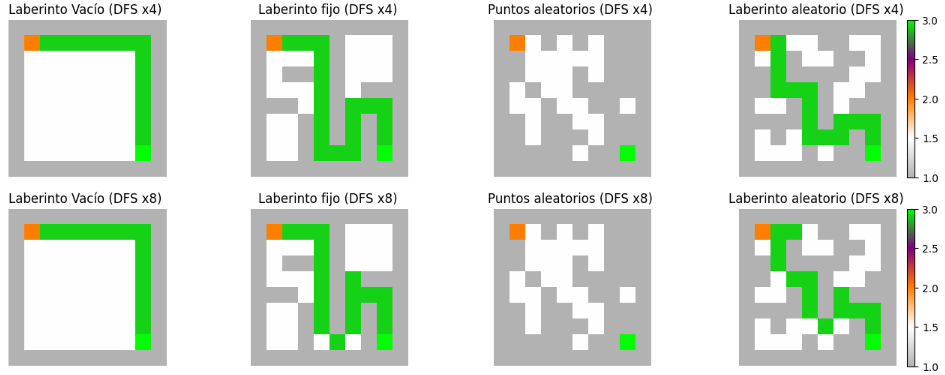